In [ ]:
!pip install optuna

In [33]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import torch.nn.functional as F
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,random_split, SubsetRandomSampler
from torch import nn
import optuna
import torch.optim as Optim
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import plotly.express as px
import time

# Dataset

## Define the dataset

For this lab. we will use one of the dataset already included in PyTorch ([https://pytorch.org/vision/stable/datasets.html](https://pytorch.org/vision/stable/datasets.html)).

**NOTE:** These dataset do not require the definition of a custom `Dataset` class, so we can focus on the network implementation.

The Fashion MNIST dataset is a colletion of Zalando's article images. The size of the images is $28 \times 28$, and there is a single channel only (black and white images) with 10 classes.

In [2]:
data_dir = 'dataset'
tr= transforms.Compose([transforms.ToTensor(),])
Train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True,transform = tr)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True, transform = tr)

## Define the dataset transform

In [3]:
train_transform = transforms.Compose([transforms.ToTensor(),])
test_transform = transforms.Compose([transforms.ToTensor(),])

## Define the dataloader

In [237]:
CompleteTrainLoader = DataLoader(Train_dataset, batch_size=256, shuffle=True)

In [4]:
train_dataset, val_dataset = random_split(Train_dataset, (50000, 10000))
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
validation_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [373]:
# print(np.size(test_dataset))
# print(iter(validation_dataloader).next()[1])
i = iter(train_dataloader)
b = next(i)
print(b[1])

tensor([0, 4, 3, 9, 0, 9, 4, 7, 3, 8, 2, 9, 0, 7, 5, 0, 3, 5, 4, 1, 2, 7, 4, 2,
        6, 1, 6, 0, 6, 8, 9, 5, 2, 9, 6, 1, 0, 2, 5, 9, 7, 7, 7, 1, 8, 9, 4, 5,
        8, 9, 0, 5, 6, 7, 9, 1, 0, 7, 6, 6, 6, 8, 0, 9, 2, 0, 9, 4, 4, 7, 4, 5,
        5, 3, 0, 7, 8, 0, 9, 5, 8, 4, 8, 8, 5, 7, 6, 6, 4, 6, 4, 1, 2, 0, 0, 3,
        7, 1, 1, 6, 5, 5, 8, 7, 8, 6, 7, 7, 0, 2, 1, 8, 3, 7, 5, 4, 4, 6, 2, 0,
        3, 7, 9, 8, 0, 0, 4, 6, 4, 9, 3, 9, 8, 2, 2, 6, 6, 2, 4, 8, 9, 1, 3, 4,
        1, 2, 8, 4, 0, 5, 9, 6, 4, 9, 4, 2, 4, 8, 8, 1, 5, 7, 4, 2, 3, 9, 0, 9,
        6, 4, 7, 4, 7, 0, 1, 4, 8, 1, 2, 8, 4, 6, 4, 1, 2, 7, 1, 2, 0, 4, 4, 8,
        0, 0, 4, 4, 1, 3, 4, 2, 9, 5, 5, 0, 4, 7, 7, 0, 3, 7, 3, 5, 1, 9, 5, 2,
        2, 7, 3, 8, 1, 1, 9, 3, 6, 0, 1, 5, 0, 4, 8, 0, 3, 9, 7, 6, 4, 1, 1, 9,
        5, 5, 7, 5, 7, 2, 9, 8, 6, 6, 8, 8, 0, 4, 2, 9])


In [5]:
# ### Plot some sample
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']

In [6]:
# kf = KFold(n_splits=2)
# print(kf.split(train_dataset))
# for i in kf.split(train_dataset):
#     print(i[1])

In [7]:
# t = []
# for i,z in enumerate(train_dataset):
#     t.append(tuple([train_transform(z[0]),z[1]]))
# v = []
# for i,z in enumerate(val_dataset):
#     v.append(tuple([train_transform(z[0]),z[1]]))

## AutoEncoder

Here we implemented two different Autoencoders.
The first on has **Three** convolutional layers and the seccond one has **four** convolutional layer in which the for the first convolutional layer the stride is one and since the kernel size is 3 the size of input image will not chenge(it will remain $28 \times 28$ after first layer).
Then we are going to tune the number of filters and in each layer, the optimizer and learning rate as hyper parameter using **Optuna** for both networks and choose the best one.

#### Autoencoder with three conv layers

In [67]:
class AE3class(nn.Module):
    
    def __init__(self, encoded_space_dim=2,NumFL1=16,NumFL2=32,NumFL3=64,latent=64):
#     def __init__(self, encoded_space_dim,NumFL1,NumFL2,NumFL3,latent):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            
            nn.Conv2d(in_channels=1, out_channels=NumFL1, kernel_size = 3,stride = 2, padding=1),
            nn.ReLU(True),
            
            nn.Conv2d(in_channels=NumFL1, out_channels=NumFL2, kernel_size = 3,stride = 2, padding=1),
            nn.ReLU(True),
            
            nn.Conv2d(in_channels=NumFL2, out_channels=NumFL3, kernel_size = 3,stride = 2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=3*3*NumFL3, out_features=latent),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=latent, out_features=encoded_space_dim)
        )
        #--------------------------------------------------------------------------------------
        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=latent),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=latent, out_features=3*3*NumFL3),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(NumFL3, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL3, out_channels=NumFL2, kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL2, out_channels=NumFL1, kernel_size=3,stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL1, out_channels=1, kernel_size=3,stride=2, padding=1, output_padding=1)
        )
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x1 = self.encoder_lin(x)
        # -----------------------------------------------
        #Apply linear layers
        x = self.decoder_lin(x1)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x,x1

#### Autoencoder with four conv layers

In [9]:
class AE4class(nn.Module):
    
    def __init__(self, encoded_space_dim,NumFL1,NumFL2,NumFL3,NumFL4,latent):
        super().__init__()
        
        #----------------------Ecoder----------------------------------------------------
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            
            nn.Conv2d(in_channels=1, out_channels=NumFL1, kernel_size = 3,stride = 1, padding=1),#this layer does not change the image size
            nn.ReLU(True),
            nn.Conv2d(in_channels=NumFL1, out_channels=NumFL2, kernel_size = 3,stride = 2, padding=1),#output size = 
            nn.ReLU(True),
            
            nn.Conv2d(in_channels=NumFL2, out_channels=NumFL3, kernel_size = 3,stride = 2, padding=1),
            nn.ReLU(True),
            
            nn.Conv2d(in_channels=NumFL3, out_channels=NumFL4, kernel_size = 3,stride = 2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=3*3*NumFL4, out_features=latent),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=latent, out_features=encoded_space_dim)
        )
        #----------------------Decoder----------------------------------------------------
        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=latent),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=latent, out_features=3*3*NumFL3),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(NumFL3, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL3, out_channels=NumFL2, kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL2, out_channels=NumFL1, kernel_size=3,stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL1, out_channels=NumFL1, kernel_size=3,stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=NumFL1, out_channels=1, kernel_size=3,stride=1, padding=1)
        )
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x1 = self.encoder_lin(x)
        # -----------------------------------------------
        #Apply linear layers
        x = self.decoder_lin(x1)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x,x1

## Training function

In [10]:
### Training function
def train_epoch(encoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    TRloss = []
    encoder.train() 
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, Label in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data,_ = encoder(image_batch)

        loss = loss_fn(encoded_data, image_batch)
        TRloss.append(loss)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return TRloss
        # Print batch loss
#         print('\t partial train loss (single batch): %f' % (loss.data))

## Testing function

In [11]:
### Testing function
def test_epoch(encoder, device, dataloader, loss_fn):
    encoder.eval()
    batchValError = []
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data,_ = encoder(image_batch)
            
            conc_out.append(encoded_data.cpu())
            conc_label.append(image_batch.cpu())
            batchValError.append(loss_fn(encoded_data,image_batch).item())
        conc_out = torch.cat(conc_out)

        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data,batchValError

In [12]:
def PlotReconstructed(org,recon,epoch,figurHeight=8,figureWidth=5): 
    fig, axs = plt.subplots(1, 2, figsize=(figurHeight,figureWidth))
    axs[0].imshow(org.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(recon.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)

In [468]:
def trainingLoop(Epoch,Model,trainL,validL,LossFun,Optimizer,plotEachEpoch=True):
    lossEpochTrain = []
    lossEpochValidation = []
    for epoch in range(Epoch):
        print('EPOCH %d/%d' % (epoch + 1, Epoch))
        lossEpochTrain = lossEpochTrain + train_epoch(encoder= Model, device= device, 
                                                      dataloader= trainL, loss_fn= LossFun, 
                                                      optimizer= Optimizer)

        valloss,temp = test_epoch(encoder= Model, device= device, 
                                  dataloader= validL, loss_fn= LossFun)
        lossEpochValidation = lossEpochValidation + temp
        print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, Epoch, valloss))

        # Get the output of a specific image (the test image at index 0 in this case)
        img = test_dataset[4][0].unsqueeze(0).to(device)
        Model.eval()
        with torch.no_grad():
            rec_img,_  = Model(img)
        if plotEachEpoch:
            PlotReconstructed(org=img,recon=rec_img,epoch=epoch)
    final_val_loss,_ = test_epoch(encoder= Model, device= device, 
                                  dataloader= validL, loss_fn= LossFun)
    return lossEpochTrain,lossEpochValidation,final_val_loss
    # Plot the reconstructed image

In [101]:
model = AE3class()
print(model)

AE3class(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=576, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=576, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(64, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 16, kernel_si

# *Comparing* **ADAM** and **Adamx** and **AdamW** optimizers
In this section we define a model with three convolutional layer(AE3class) with the default parameters defined in the class and train the network for 10 epoch to compare the output.

In [81]:
#Adam
epoch = 1
torch.manual_seed(0)
modelADAM = AE3class()
params_to_optimize = modelADAM.parameters()
optim = torch.optim.Adam(params_to_optimize, lr=0.005)

In [82]:
Time = time.time()

trainErrorADAM,valErrorADAM,finalErrADAM = trainingLoop(Epoch=epoch,Model=modelADAM,
                                                        trainL=train_dataloader,
                                                        validL=validation_dataloader,
                                                        LossFun=loss_fn,Optimizer=optim,
                                                        plotEachEpoch=False)
print("the training time for {} epochs is {} minutes".format(epoch,(time.time()-Time)/60) )

EPOCH 1/1
tensor(0.0338)


	 VALIDATION - EPOCH 1/1 - loss: 0.033803


the training time for 1 epochs is 0.5457025249799092 minutes


In [83]:
device = "cpu"# "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = torch.nn.MSELoss()

In [84]:
#Adamx
modelAdamx = AE3class()
params_to_optimize = modelAdamx.parameters()
optim = torch.optim.Adamax(params_to_optimize, lr=0.005)

In [85]:
Time = time.time()

trainErrorADAMx,valErrorADAMx,finalErrADAMx = trainingLoop(Epoch=epoch,Model=modelAdamx,
                                                        trainL=train_dataloader,
                                                        validL=validation_dataloader,
                                                        LossFun=loss_fn,Optimizer=optim,
                                                        plotEachEpoch=False)
print("the training time for {} epochs is {} minutes".format(epoch,(time.time()-Time)/60) )

EPOCH 1/1
tensor(0.0401)


	 VALIDATION - EPOCH 1/1 - loss: 0.040087


the training time for 1 epochs is 0.6273259838422139 minutes


In [86]:
#AdamW
torch.manual_seed(0)
modelAdamW = AE3class(encoded_space_dim = 2,NumFL1=16,NumFL2=32,NumFL3=64,latent=64)
params_to_optimize = modelAdamW.parameters()
optim = torch.optim.AdamW(params_to_optimize, lr=0.01)

In [87]:
#AdamW

Time = time.time()
trainErrorAdamW,valErrorAdamW,finalErrAdamW = trainingLoop(Epoch=epoch,Model=modelAdamW,
                                                     trainL=train_dataloader,validL=validation_dataloader,
                                                     LossFun=loss_fn,Optimizer=optim,plotEachEpoch=False)
print("the training time for {} epochs is {} minutes".format(epoch,(time.time()-Time)/60) )

EPOCH 1/1
tensor(0.0324)


	 VALIDATION - EPOCH 1/1 - loss: 0.032373


the training time for 1 epochs is 0.5989850918451946 minutes


In [88]:
def TtoN(A):
    t = []
    for i in A:
        t.append(i.detach().numpy())
    return t

Text(0.5, 0, 'Epoch')

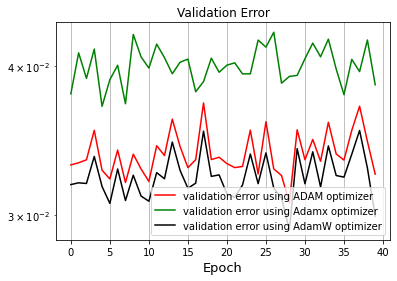

In [89]:
fig, ax = plt.subplots()
ax.semilogy(range(len(valErrorADAM)),valErrorADAM,c='r',label="validation error using ADAM optimizer")
ax.semilogy(range(len(valErrorADAMx)),valErrorADAMx,c='g',label="validation error using Adamx optimizer")
ax.semilogy(range(len(valErrorAdamW)),valErrorAdamW,c='k',label="validation error using AdamW optimizer")
leg = ax.legend()
ax.grid(True)
ax.set_title('Validation Error')
ax.set_xlabel('Epoch', fontsize=13)

In [90]:
adam = TtoN(trainErrorADAM)
adamx = TtoN(trainErrorADAMx)
adamW = TtoN(trainErrorAdamW)

Text(0.5, 0, 'Epoch')

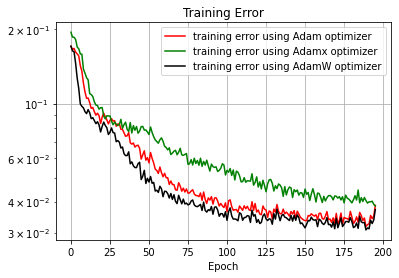

In [91]:
fig, ax = plt.subplots()
ax.semilogy(range(len(adam)),adam,c='r',label="training error using Adam optimizer")
ax.semilogy(range(len(adamx)),adamx,c='g',label="training error using Adamx optimizer")
ax.semilogy(range(len(adamW)),adamW,c='k',label="training error using AdamW optimizer")
leg = ax.legend()
ax.grid(True)
ax.set_title('Training Error')
ax.set_xlabel('Epoch')

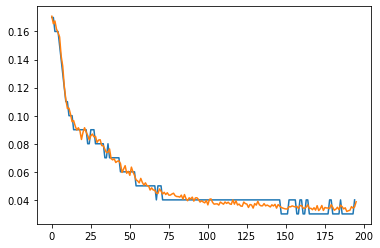

In [100]:
plt.plot(moving_averages)
plt.plot(adam)

## Optuna
In this part we define the objective function that we are going to optimize using optuna.
**Note** that I tried training the network using SGD optimizer but the output loss was usually higher than using Adam. Therefor, for better results and less computation time I decided to use only Adam and RAdam as optimizers.
Another parameter that could be used as hyperparameter is **kernel** **size** but because the size of input image is small, using kernel size with size of 5 or 3 will not make much difference so I used fixed kernel size(kenel_size = 3).

In [ ]:
def obj(trial):
    cfg = { 
          'device' : "cuda" if torch.cuda.is_available() else "cpu",
          'train_batch_size' : 64,
          'n_epochs' : 2,
          'seed' : 0,
          'log_interval' : 100,
          'save_model' : False,
          'lr' : trial.suggest_loguniform('lr', 1e-4, 5e-2),
#           'momentum': trial.suggest_uniform('momentum', 0.4, 0.99),
          'optimizer': trial.suggest_categorical('optimizer',["RAdam","Adam"]),
          'activation': F.relu,
          'space_dim':trial.suggest_discrete_uniform('space_dim',2,3,1),
          'NumF1':trial.suggest_discrete_uniform('NumF1',8,16,4),
          'NumF2':trial.suggest_discrete_uniform('NumF2',16,32,8),
          'NumF3':trial.suggest_discrete_uniform('NumF3',32,64,16),
          'latent_layer':trial.suggest_discrete_uniform('latent_layer',64,128,32),
          'p':0.1,
          }

    torch.manual_seed(cfg['seed'])
    model = AE3class(int(cfg['space_dim']),int(cfg['NumF1']),int(cfg['NumF2']),int(cfg['NumF3']),int(cfg['latent_layer']))
    if torch.cuda.is_available():
        model.cuda()
    optimizer = getattr(Optim, cfg['optimizer'])(model.parameters(), lr=cfg['lr'])
    print("")
    for epoch in range(1, cfg['n_epochs'] + 1):
        train_epoch(encoder=model,device=cfg['device'],
                    dataloader=train_dataloader,loss_fn=loss_fn,
                    optimizer=optimizer)
    val_loss,_ = test_epoch(encoder=model,device=device, 
                            dataloader=validation_dataloader, 
                            loss_fn=loss_fn)
    return val_loss

In [ ]:
loss_fn = torch.nn.MSELoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(),direction="minimize")
study.optimize(obj, n_trials=20, timeout=60000)

In [ ]:
print("  Number of finished trials: ", len(study.trials))
# print("  Number of pruned trials: ", len(pruned_trials))
# print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

# Training the network with best parameters
### Initialize the network with best parameters.

In [469]:
torch.manual_seed(0)
encoded_space_dim = 2
bestParams = {'lr': 0.004438058656952217, 'optimizer': 'Adam', 'NumF1': 16,
              'NumF2': 32, 'NumF3': 64, 'latent_layer': 94}
ModelAE = AE3class(encoded_space_dim=2,NumFL1=int(bestParams['NumF1']),NumFL2=int(bestParams['NumF2']),
                   NumFL3=int(bestParams['NumF3']),latent=int(bestParams['latent_layer']))
# decoder = Decoder(encoded_space_dim=encoded_space_dim)


In [470]:
loss_fn = torch.nn.MSELoss()
lr = bestParams['lr'] # Learning rate
params_to_optimize = ModelAE.parameters() 
optim = torch.optim.Adam(params_to_optimize, lr=lr)
# Check if the GPU is available
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
# ModelAE.to(device)
# decoder.to(device)

### Training loop

EPOCH 1/20


	 VALIDATION - EPOCH 1/20 - loss: 0.026538




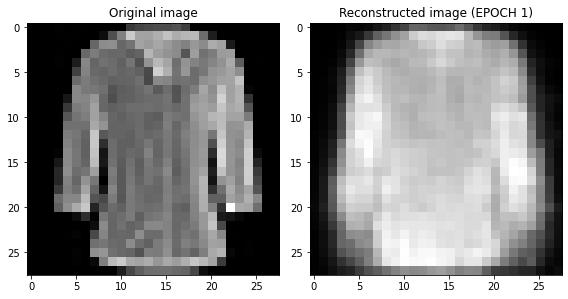

EPOCH 2/20


	 VALIDATION - EPOCH 2/20 - loss: 0.026419




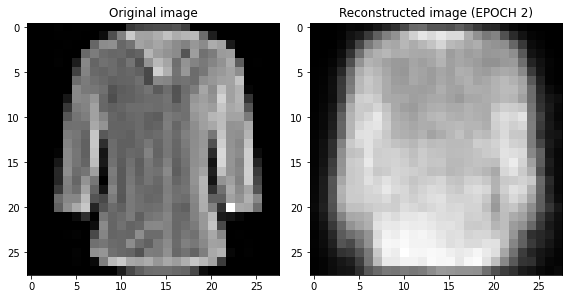

EPOCH 3/20


	 VALIDATION - EPOCH 3/20 - loss: 0.026220




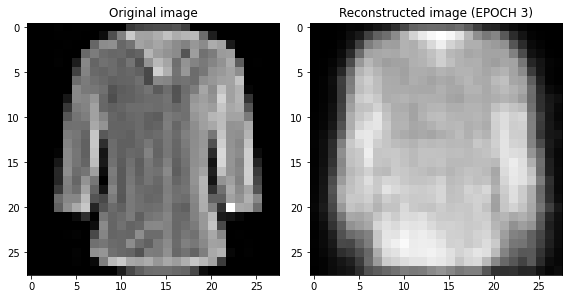

EPOCH 4/20


	 VALIDATION - EPOCH 4/20 - loss: 0.026443




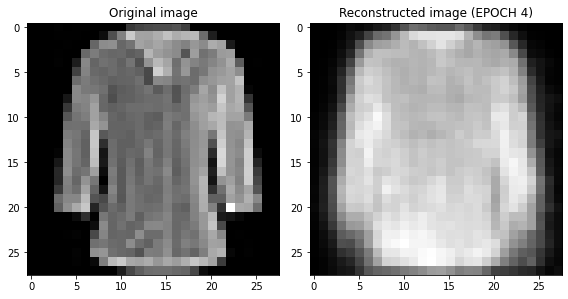

EPOCH 5/20


	 VALIDATION - EPOCH 5/20 - loss: 0.026165




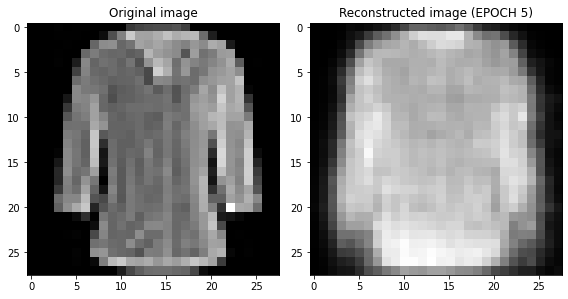

EPOCH 6/20


	 VALIDATION - EPOCH 6/20 - loss: 0.026054




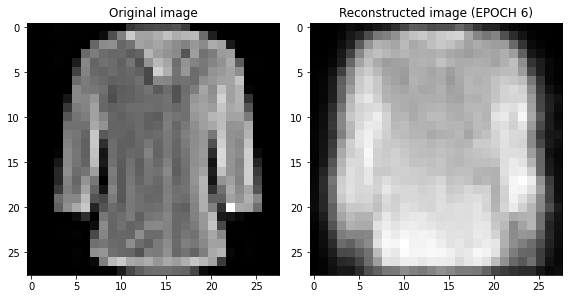

EPOCH 7/20


	 VALIDATION - EPOCH 7/20 - loss: 0.026028




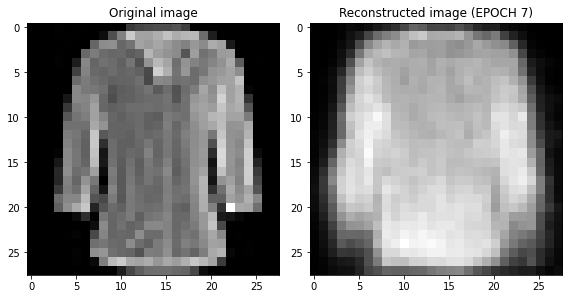

EPOCH 8/20


	 VALIDATION - EPOCH 8/20 - loss: 0.026000




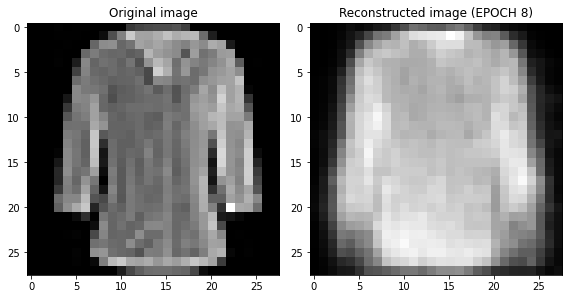

EPOCH 9/20


	 VALIDATION - EPOCH 9/20 - loss: 0.025985




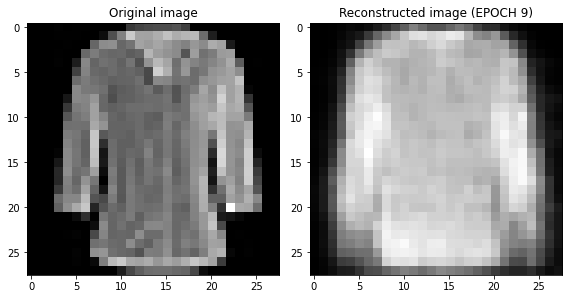

EPOCH 10/20


	 VALIDATION - EPOCH 10/20 - loss: 0.025596




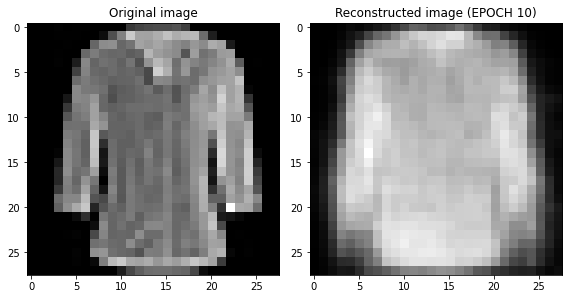

EPOCH 11/20


	 VALIDATION - EPOCH 11/20 - loss: 0.025787




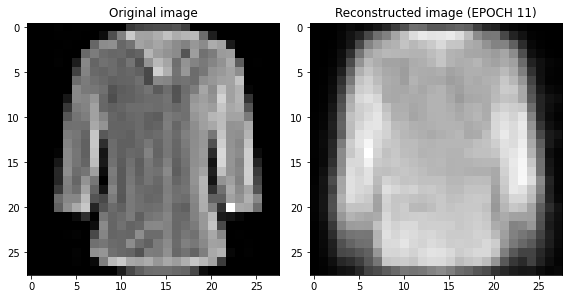

EPOCH 12/20


	 VALIDATION - EPOCH 12/20 - loss: 0.025950




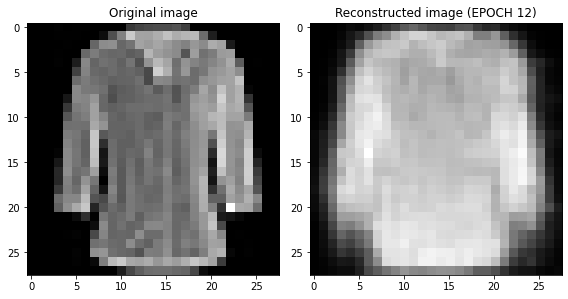

EPOCH 13/20


	 VALIDATION - EPOCH 13/20 - loss: 0.025324




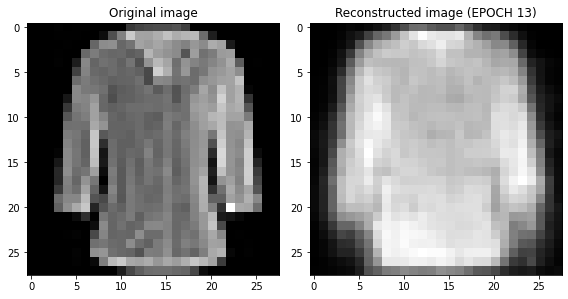

EPOCH 14/20


	 VALIDATION - EPOCH 14/20 - loss: 0.025668




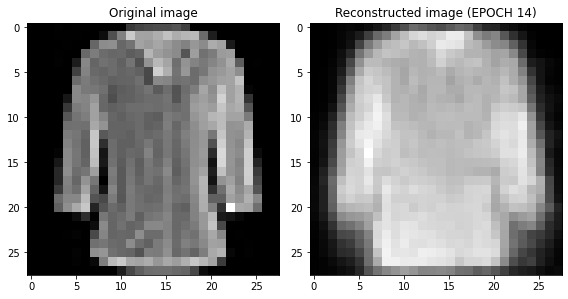

EPOCH 15/20


	 VALIDATION - EPOCH 15/20 - loss: 0.025228




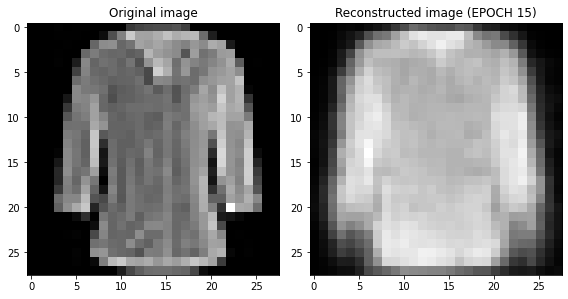

EPOCH 16/20


	 VALIDATION - EPOCH 16/20 - loss: 0.025214




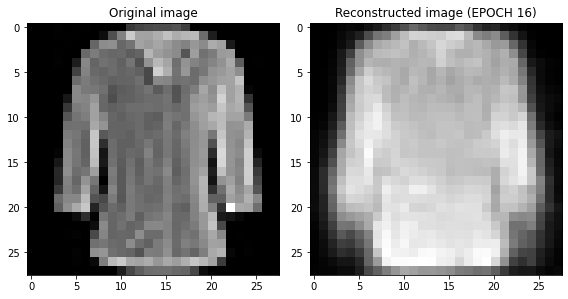

EPOCH 17/20


	 VALIDATION - EPOCH 17/20 - loss: 0.025230




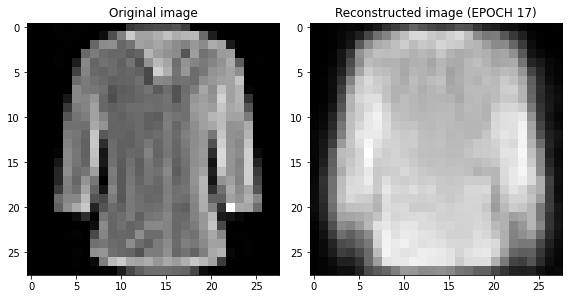

EPOCH 18/20


	 VALIDATION - EPOCH 18/20 - loss: 0.025743




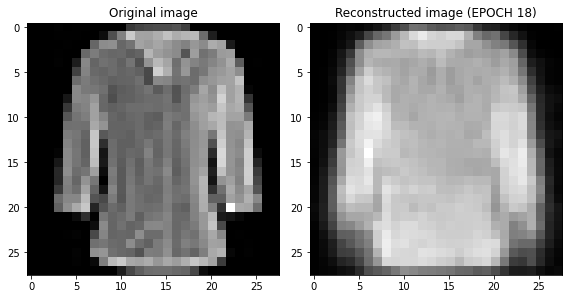

EPOCH 19/20


	 VALIDATION - EPOCH 19/20 - loss: 0.025114




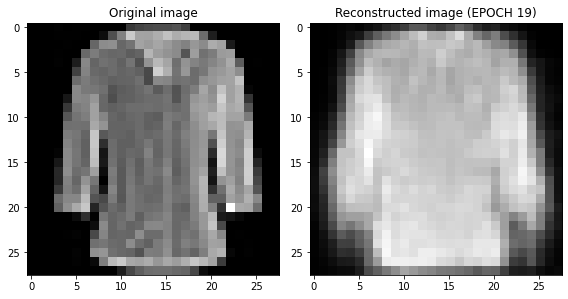

EPOCH 20/20


	 VALIDATION - EPOCH 20/20 - loss: 0.025220




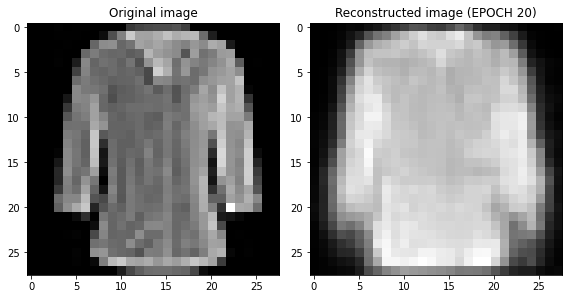

In [497]:
tre,vale,finalerr = trainingLoop(Epoch=20,Model=ModelAE,
                                 trainL=CompleteTrainLoader,
                                 validL=test_dataloader,
                                 LossFun=loss_fn,Optimizer=optim)

In [498]:
PATH = "t.pth"
torch.save(ModelAE.state_dict(), PATH)

Text(0.5, 0, 'Epoch')

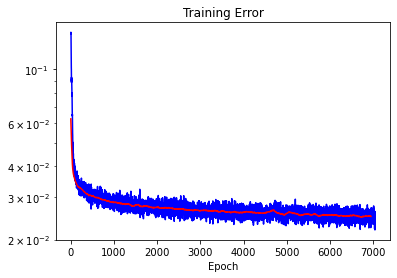

In [264]:
adam = TtoN(tre)
n = 100
r = np.convolve(adam, np.ones(n,)/n, mode='valid')
fig, ax = plt.subplots()
ax.semilogy(range(len(adam)),adam,c='b',label="training error using Adam optimizer")
ax.semilogy(range(len(r)),r,c='r',label="training error using Adam optimizer")
ax.set_title('Training Error')
ax.set_xlabel('Epoch')


Text(0.5, 0, 'Epoch')

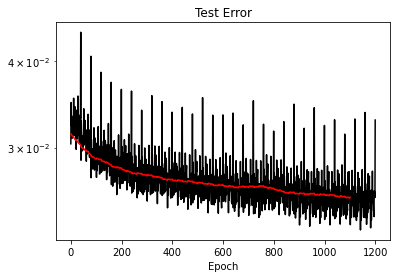

In [262]:
fig, ax = plt.subplots()
r = np.convolve(vale, np.ones(n,)/n, mode='valid')
ax.semilogy(range(len(vale)),vale,c='k',label="test error using ADAM optimizer")
ax.semilogy(range(len(r)),r,c='r',label="training error using Adam optimizer")
# leg = ax[0].legend()
# ax.grid(True)
ax.set_title('Test Error')
ax.set_xlabel('Epoch')

## k-fold cross validation

In [265]:
def Mean(k):
    z = []
    for i in k:
        z.append(i.detach().numpy())
    return sum(z)/len(z)

In [267]:
torch.manual_seed(0)
encoded_space_dim = 2
bestParams = {'lr': 0.004438058656952217, 'optimizer': 'Adam', 'NumF1': 16,
              'NumF2': 32, 'NumF3': 64, 'latent_layer': 94}
ModelAE = AE3class(encoded_space_dim=2,NumFL1=int(bestParams['NumF1']),NumFL2=int(bestParams['NumF2']),
                   NumFL3=int(bestParams['NumF3']),latent=int(bestParams['latent_layer']))
k = 5 # number of folds
kfold = KFold(n_splits=k, shuffle=True)
kfoldErrors = []
for fold, (train_ids, test_ids) in enumerate(kfold.split(Train_dataset)):
    
    # Print
    print(f'FOLD {fold}')
    print('------------------------------------------')
    kfmodel = AE3class(encoded_space_dim=2,NumFL1=int(bestParams['NumF1']),NumFL2=int(bestParams['NumF2']),
                   NumFL3=int(bestParams['NumF3']),latent=int(bestParams['latent_layer']))
    params_to_optimize = kfmodel.parameters()
    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(Train_dataset,batch_size=256, 
                                              sampler=train_subsampler)
    
    testloader = torch.utils.data.DataLoader(Train_dataset,batch_size=256, 
                                             sampler=test_subsampler)
    
    tre,vale,f = trainingLoop(Epoch=1,Model=kfmodel,
                            trainL=train_dataloader,
                            validL=validation_dataloader,LossFun=loss_fn,
                            Optimizer=optim,plotEachEpoch=False)
    print("the validation erro of fold %d : "%fold)
    print(f)
    kfoldErrors.append(f)


FOLD 0
------------------------------------------
EPOCH 1/1
tensor(0.0351)


	 VALIDATION - EPOCH 1/1 - loss: 0.035084


the validation erro of fold 0 : 
tensor(0.0351)
FOLD 1
------------------------------------------
EPOCH 1/1
tensor(0.0346)


	 VALIDATION - EPOCH 1/1 - loss: 0.034592


the validation erro of fold 1 : 
tensor(0.0346)
FOLD 2
------------------------------------------
EPOCH 1/1
tensor(0.0352)


	 VALIDATION - EPOCH 1/1 - loss: 0.035153


the validation erro of fold 2 : 
tensor(0.0352)
FOLD 3
------------------------------------------
EPOCH 1/1
tensor(0.0341)


	 VALIDATION - EPOCH 1/1 - loss: 0.034104


the validation erro of fold 3 : 
tensor(0.0341)
FOLD 4
------------------------------------------
EPOCH 1/1
tensor(0.0341)


	 VALIDATION - EPOCH 1/1 - loss: 0.034060


the validation erro of fold 4 : 
tensor(0.0341)


In [271]:
print("The k-fold cross validation loss is:",np.mean(kfoldErrors))

The k-fold cross validation loss is: 0.03459858


# Fine tuning for classification task 
firt we load the model we obtained after optuning
Then by adding a fully connected layer of ten nuerons we define a new network and retrain it for the task of classification.

In [439]:
Loss_fn = nn.CrossEntropyLoss() 
loadedM = AE3class(encoded_space_dim=2,NumFL1=int(bestParams['NumF1']),NumFL2=int(bestParams['NumF2']),
                   NumFL3=int(bestParams['NumF3']),latent=int(bestParams['latent_layer']))
PATH = "BestModel.pth"
loadedM.load_state_dict(torch.load(PATH)) 
params_to_optimize = encoder.parameters()
optim = torch.optim.Adam(params_to_optimize, lr=0.00839, weight_decay=1e-5)
print(loadedM)

AE3class(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=576, out_features=94, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=94, out_features=2, bias=True)
  )
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=94, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=94, out_features=576, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(64, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 16, kernel_si

In [440]:
class finetune(nn.Module):
    def __init__(self):
        super().__init__()
        self.convlayer = (loadedM.encoder_cnn)
        self.fc = (loadedM.encoder_lin[0:1])
        self.flatten = nn.Flatten(start_dim=1)
        self.out = nn.Linear(in_features=94,out_features=10)
    def forward(self, x):
        # Apply convolutions
        x = self.convlayer(x)
        # Flatten
        x = self.flatten(x)
        x = self.fc(x)
        x = self.out(x)
        return x

In [455]:
fineTunModel = finetune()
params_to_optimize = fineTunModel.parameters()
optim = torch.optim.Adam(params_to_optimize, lr=0.005)
# for layer in fineTunModel.children():
#     if hasattr(layer, 'reset_parameters'):
#         layer.reset_parameters()

In [388]:
def accuracy(a,b):
    acc = 0
    length = len(a)
    blen = len(b)
    if length == blen:
        for index,i in enumerate(a):
            if i == b[index]:
                acc = acc + 1
    else:
        print('lists are not of the same length')
    return acc/length

In [385]:
### Training function
def Train_epoch(encoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    TRloss = []
    encoder.train() 
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, Label in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        output = encoder(image_batch)
        loss = loss_fn(output, Label)
        TRloss.append(loss)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return TRloss
        # Print batch loss
#         print('\t partial train loss (single batch): %f' % (loss.data))

In [443]:
### Testing function
def Test_epoch(encoder, device, dataloader, loss_fn):
    encoder.eval()
    batchValError = []
    acc = []
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, Label in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            Label = Label.to(device)
            # Encode data
            output = encoder(image_batch)
            
            conc_out.append(output.cpu())
            conc_label.append(Label.cpu())
            batchValError.append(loss_fn(output,Label).item())
            acc.append(accuracy(output.argmax(dim=1),Label))
        conc_out = torch.cat(conc_out)

        conc_label = torch.cat(conc_label)
        
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data,batchValError,acc

In [456]:
Epoch = 3
training_loss = []
validation_error = []
Accuracy = []
currentTime = time.time()
for epoch in range(Epoch):
    training_loss.append(Train_epoch(encoder=fineTunModel,
                        device =device ,
                        dataloader=train_dataloader,
                        loss_fn=Loss_fn,
                        optimizer=optim))
    _,temp,temp2 = Test_epoch(encoder=fineTunModel,device=device,
                        dataloader=validation_dataloader,
                        loss_fn=Loss_fn)
    Accuracy.append(temp2)
    validation_error.append(temp)
    print(sum(temp2)/len(temp2))
print("-------------------")
print("training time for {} epochs is:{} minutes".format(Epoch,(time.time()-currentTime)/60))
print("-------------------")

0.887890625
0.88701171875
0.8892578125
-------------------
training time for 3 epochs is:0.882159439722697 minutes
-------------------


main label : 7
predicted label :  7


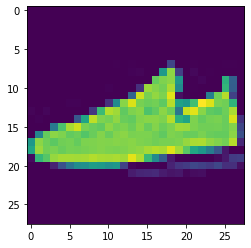

In [457]:
data_iter = iter(validation_dataloader)
im , label = data_iter.next()
image = im[0]
print("main label :",label[0].detach().numpy())
plt.imshow(image.squeeze())
l = fineTunModel(image.unsqueeze(dim=1)).detach().numpy()[0]
print("predicted label : ",l.argmax())

# Network Analysis

If you have a previously saved network, restore the network parameters.

In [ ]:
! pip install plotly==5.5.0

In [499]:
# Load network parameters
loadedM = AE3class(encoded_space_dim=2,NumFL1=int(bestParams['NumF1']),NumFL2=int(bestParams['NumF2']),
                   NumFL3=int(bestParams['NumF3']),latent=int(bestParams['latent_layer']))
PATH = "t.pth"
loadedM.load_state_dict(torch.load(PATH))

<All keys matched successfully>

The encoder can be used to evaluate the latent space values for each of the test images. Since we used an encoded space dimension of 2, the encoder maps an entire image to just 2 floating point numbers.

We also save the corresponding label to show how each digit is mapped in the encoded space.

In [500]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        _,encoded_img  = ModelAE(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:11<00:00, 884.37it/s]


In [501]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,label
0,-1.553880,-2.952381,9
1,-2.777975,6.892980,2
2,9.898651,2.935644,1
3,4.891535,1.051273,1
4,-1.371647,1.638359,6
...,...,...,...
9995,-3.941340,-4.222011,9
9996,3.046612,0.266051,1
9997,1.307455,1.562442,8
9998,7.656428,0.012447,1


This graph shows where each input image is mapped in the encoded space. Since we have just 2 encoded variables, we can easily plot them in a bidimensional space. 

In [502]:
px.scatter(encoded_samples,x='Enc. Variable 0', y='Enc. Variable 1',
           color=[label_names[l] for l in encoded_samples.label.to_numpy()],
           opacity=0.7)

### performing pca and t-sne on 2D latent space

In [510]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
# encoded_samples_reduced_PCA
encoded_samples_pca = pd.DataFrame(encoded_samples_reduced_PCA)
px.scatter(encoded_samples_pca,x=0, y=1,
           color=[label_names[l] for l in encoded_samples.label.to_numpy()],
           opacity=0.7)

In [512]:
tsne = TSNE(n_components=2)
encoded_samples_reduced_PCA = tsne.fit_transform(encoded_samples)
# encoded_samples_reduced_PCA
encoded_samples_tsne = pd.DataFrame(encoded_samples_reduced_PCA)
px.scatter(encoded_samples_tsne,x=0, y=1,
           color=[label_names[l] for l in encoded_samples.label.to_numpy()],
           opacity=0.7)

As you can see from the graph, even if we never used the labels (i.e. the id of the class in the image) during the training, the network has been able to clusterize quite well the different classes.

> **NOTE**
> 
> The encoded space may have many more variables. In this case you can still have a visual representation of the encoded space by applying a dimensionality reduction method, such as:
- [Principal Component Analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [t-distributed Stochastic Neighbor Embedding (t-SNE)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)




While the encoder is able to map the image to the encoded space, the decoder can do the opposite, generating an image given the corresponding latent space values.

The latent space can also be manually customized, like in the following example, where we generate images with the decoder by providing custom latent space variables.

## Extracting the generator part of the Autoencoder
since we defined both the encoder and decoder(generator) parts in one single class here for generating new samples from latent space we need to have the encoder seperately.

In [503]:
class generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder_lin = (loadedM.decoder_lin)
        self.unflatten = (loadedM.unflatten)
        self.decoder_conv = loadedM.decoder_conv
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        return x

In [504]:
Generator = generator()

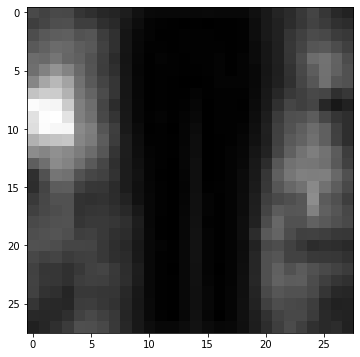

In [508]:
if encoded_space_dim == 2:
    # Generate a custom sample
    custom_encoded_sample = [8, 1]
    encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

    # Decode sample
    Generator.eval()
    with torch.no_grad():
        generated_img  = Generator(encoded_value)

    plt.figure(figsize=(8,6))
    plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='binary')
    plt.show()

# Further insights on PCA and t-SNE

Let's do the same training again, with encoded dimension equal to 10.

Selected device: cpu
EPOCH 1/2


	 VALIDATION - EPOCH 1/2 - loss: 0.023530




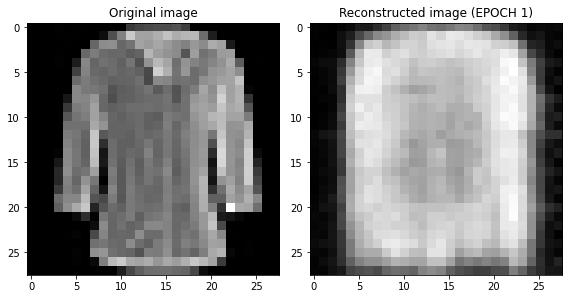

EPOCH 2/2


	 VALIDATION - EPOCH 2/2 - loss: 0.018737




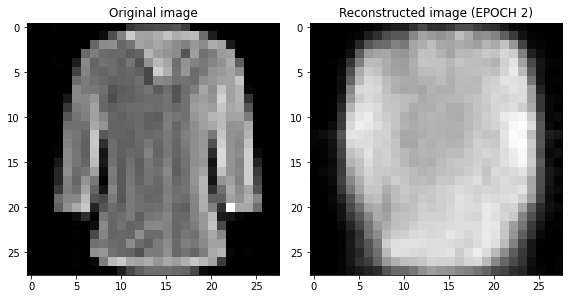

In [513]:
torch.manual_seed(0)
encoded_space_dim = 10
bestParams = {'lr': 0.005, 'optimizer': 'Adam', 'NumF1': 16,
              'NumF2': 32, 'NumF3': 64, 'latent_layer': 94}
ModelAE10 = AE3class(encoded_space_dim=encoded_space_dim,NumFL1=int(bestParams['NumF1']),NumFL2=int(bestParams['NumF2']),
                   NumFL3=int(bestParams['NumF3']),latent=int(bestParams['latent_layer']))


### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = ModelAE10.parameters()
optim = torch.optim.Adam(params_to_optimize, lr=bestParams['lr'])

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
ModelAE10.to(device)


### Training cycle
epochs = 2
trainErrorADAM,valErrorADAM,finalErrADAM = trainingLoop(Epoch=epoch,Model=ModelAE10,
                                                        trainL=train_dataloader,
                                                        validL=validation_dataloader,
                                                        LossFun=loss_fn,Optimizer=optim,
                                                        plotEachEpoch=True)
# for epoch in range(num_epochs):
#     print('EPOCH %d/%d' % (epoch + 1, num_epochs))
#     ### Training (use the training function)
#     train_epoch(encoder=ModelAE10, 
#                 device=device, 
#                 dataloader=train_dataloader, 
#                 loss_fn=loss_fn, 
#                 optimizer=optim)
#     ### Validation  (use the testing function)
#     val_loss = test_epoch(
#         encoder=ModelAE10, 
#         device=device, 
#         dataloader=test_dataloader, 
#         loss_fn=loss_fn)
#     # Print Validationloss
#     print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

#     ### Plot progress
#     # Get the output of a specific image (the test image at index 0 in this case)
#     img = test_dataset[0][0].unsqueeze(0).to(device)
#     encoder.eval()
#     decoder.eval()
#     with torch.no_grad():
#         rec_img  = decoder(encoder(img))
#     # Plot the reconstructed image
#     fig, axs = plt.subplots(1, 2, figsize=(12,6))
#     axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
#     axs[0].set_title('Original image')
#     axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
#     axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
#     plt.tight_layout()
#     plt.pause(0.1)
#     # Save figures
#     os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
#     fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
#     plt.show()
#     plt.close()

In [516]:
### Get the encoded representation of the test samples
torch.manual_seed(0)
encoded_space_dim = 10
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

bestParams = {'lr': 0.005, 'optimizer': 'Adam', 'NumF1': 16,
              'NumF2': 32, 'NumF3': 64, 'latent_layer': 94}
ModelAE10 = AE3class(encoded_space_dim=encoded_space_dim,NumFL1=int(bestParams['NumF1']),NumFL2=int(bestParams['NumF2']),
                   NumFL3=int(bestParams['NumF3']),latent=int(bestParams['latent_layer']))
PATH =  "AE10.pth"
ModelAE10.load_state_dict(torch.load(PATH),map_location=torch.device('cpu')) 
ModelAE10.to(device)
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    ModelAE10.eval()
    with torch.no_grad():
        _,encoded_img  = ModelAE10(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

**How can we visualize data?** we like 2D-3D plots for intuition!

PCA and tSNE come into play.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
encoded_samples_reduced_PCA

In [ ]:
Encoded_samples = pd.DataFrame(encoded_samples_reduced_PCA)
Encoded_samples

In [ ]:
px.scatter(Encoded_samples,x=0, y=1,
           color=[label_names[l] for l in encoded_samples.label.to_numpy()],
           opacity=0.7)

In [ ]:
tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)
Encoded_samples_tsne = pd.DataFrame(encoded_samples_reduced_TSNE)
Encoded_samples_tsne
# plt.scatter(encoded_samples_reduced_TSNE[:,0], encoded_samples_reduced_TSNE[:,1], c=encoded_samples.label.to_numpy())

In [ ]:
px.scatter(Encoded_samples_tsne,x=0, y=1,
           color=[label_names[l] for l in encoded_samples.label.to_numpy()],
           opacity=0.7)

Given a point cloud:
*   **PCA** is like taking a snapshot from a different perspective/angle (linear only)
*   **tSNE** is like taking a snapshot from a different perspective/angle and at the same time stretching the space (non-linear)


# variational Autoencoder

In [ ]:
class VAE(nn.Module):
    
    def __init__(self, encoded_space_dim,NumFL1,NumFL2,NumFL3,latent):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=NumFL1, kernel_size = 3,stride = 2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=NumFL1, out_channels=NumFL2, kernel_size = 3,stride = 2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=NumFL2, out_channels=NumFL3, kernel_size = 3,stride = 2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=3*3*NumFL3, out_features=latent),
            nn.ReLU(True),
            # Second linear layer
#             nn.Linear(in_features=latent, out_features=encoded_space_dim)
        )
        ### variational part
        self.Mean = nn.Linear(in_features=latent,out_features=encoded_space_dim)
        self.LogSigma = nn.Linear(in_features=latent,out_features=encoded_space_dim)
        ### 
        
        
        #--------------------------------------------------------------------------------------
        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=latent),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=latent, out_features=3*3*NumFL3),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(NumFL3, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL3, out_channels=NumFL2, kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL2, out_channels=NumFL1, kernel_size=3,stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL1, out_channels=1, kernel_size=3,stride=2, padding=1, output_padding=1)
        )
    def distribution(self,mean,Logvariance):
            ebsilon = torch.randn_like(mean)# the same as torch.randn(mean.size[0],mean.size[1])
            return mean + ebsilon * torch.exp(Logvariance/2)
    def forward(self, x):
        x = self.encoder_cnn(x)# Apply convolutions
        x = self.flatten(x)# Flatten
        # # Apply linear layers
        x = self.encoder_lin(x)
        M = self.Mean(x)
        S = self.LogSigma(x)
        Z = self.distribution(M,S)
        # -----------------------------------------------
        #Apply linear layers
        x = self.decoder_lin(Z)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x,Z,M,S

In [ ]:
VAEmodel = VAE(encoded_space_dim=2,NumFL1=16,NumFL2=32,NumFL3=64,latent=64)
lossFunction = F.mse_loss

In [ ]:
            kl_div = -0.5 * torch.sum(1 + z_log_var 
                                      - z_mean**2 
                                      - torch.exp(z_log_var), 
                                      axis=1) # sum over latent dimension

            batchsize = kl_div.size(0)
            kl_div = kl_div.mean() # average over batch dimension
    
            pixelwise = loss_fn(decoded, features, reduction='none')
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
            pixelwise = pixelwise.mean() # average over batch dimension
            
            loss = reconstruction_term_weight*pixelwise + kl_div

In [ ]:
def KL_Loss(mean,LogVar):
    kl_div = -0.5 * torch.sum(1 + LogVar - mean**2  - torch.exp(LogVar), axis=1) # sum over latent dimension
    batchsize = kl_div.size(0)
    kl_div = kl_div.mean()
    return kl_div,batchsize

In [ ]:
### Training function
def train_epoch_VAE(encoder, device, dataloader, loss_fn, optimizer,alpha):
    # Set train mode for both the encoder and the decoder
    encoder.train()
#     decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)

        outImage,Z,mean,LogVar = encoder(image_batch)

        # Evaluate loss
#         print(mean)
#         print(LogVar)
        kl_loss,BatchSize = KL_Loss(mean,LogVar)
#         print("----")
#         print(kl_loss)
#         print(BatchSize)
#         print(np.shape(image_batch))
        loss = lossFunction(outImage, image_batch, reduction='none')
#         print(loss.size)
        loss = loss.view(BatchSize,-1).sum(axis = 1)
        loss = loss.mean()
        print(loss)
#         pixelwise = loss_fn(decoded, features, reduction='none')
#         pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
#         pixelwise = pixelwise.mean() # average over batch dimension

#         loss = reconstruction_term_weight*pixelwise + kl_div

        
        loss = alpha*loss + kl_loss
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
#         print('\t partial train loss (single batch): %f' % (loss.data))

In [ ]:
### Testing function
def test_epochVAE(encoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            outImage,_,_,_= encoder(image_batch)
            
            # Append the network output and the original image to the lists
            conc_out.append(outImage.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
### Training cycle
num_epochs = 10
alpha = 1
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    
    """" --------------- Training ---------------------"""
    train_epoch_VAE(encoder = VAEmodel,device = device,dataloader = train_dataloader,loss_fn = loss_fn,optimizer = optim,alpha=alpha)
    
    ### Validation  (use the testing function)
    val_loss = test_epochVAE(encoder=VAEmodel,device=device,dataloader=test_dataloader,
                          loss_fn=loss_fn)
    # Print Validationloss
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[0][0].unsqueeze(0).to(device)
    VAEmodel.eval()
#     decoder.eval()
    with torch.no_grad():
        rec_img,_,_,_  = VAEmodel(img)
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

    # Save network parameters
    torch.save(VAEmodel.state_dict(), 'encoder_params.pth')
#     torch.save(decoder.state_dict(), 'decoder_params.pth')

    # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training

In [ ]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    VAEmodel.eval()
    with torch.no_grad():
        _,encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import sampler


class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Parameters:
        ------------
        tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        
        Returns:
        ------------
        Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples


def get_dataloaders_cifar10(batch_size, num_workers=0,
                            validation_fraction=None,
                            train_transforms=None, test_transforms=None):

    if train_transforms is None:
        train_transforms = transforms.ToTensor()

    if test_transforms is None:
        test_transforms = transforms.ToTensor()

    train_dataset = datasets.CIFAR10(root='data',
                                     train=True,
                                     transform=train_transforms,
                                     download=True)

    valid_dataset = datasets.CIFAR10(root='data',
                                     train=True,
                                     transform=test_transforms)

    test_dataset = datasets.CIFAR10(root='data',
                                    train=False,
                                    transform=test_transforms)


    if validation_fraction is not None:
        num = int(validation_fraction * 50000)
        train_indices = torch.arange(0, 50000 - num)
        valid_indices = torch.arange(50000 - num, 50000)

        #train_sampler = SubsetRandomSampler(train_indices)
        #valid_sampler = SubsetRandomSampler(valid_indices)
        train_sampler = ChunkSampler(train_indices.shape[0], 0)
        valid_sampler = ChunkSampler(valid_indices.shape[0], train_indices.shape[0])

        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  sampler=valid_sampler)

        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  drop_last=True,
                                  sampler=train_sampler)

    else:
        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  shuffle=True)

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)

    if validation_fraction is None:
        return train_loader, test_loader
    else:
        return train_loader, valid_loader, test_loader


def get_dataloaders_mnist(batch_size, num_workers=0,
                          validation_fraction=None,
                          train_transforms=None, test_transforms=None):

    if train_transforms is None:
        train_transforms = transforms.ToTensor()

    if test_transforms is None:
        test_transforms = transforms.ToTensor()

    train_dataset = datasets.MNIST(root='data',
                                   train=True,
                                   transform=train_transforms,
                                   download=True)

    valid_dataset = datasets.MNIST(root='data',
                                   train=True,
                                   transform=test_transforms)

    test_dataset = datasets.MNIST(root='data',
                                  train=False,
                                  transform=test_transforms)

    if validation_fraction is not None:
        num = int(validation_fraction * 60000)
        train_indices = torch.arange(0, 60000 - num)
        valid_indices = torch.arange(60000 - num, 60000)

        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(valid_indices)

        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  sampler=valid_sampler)

        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  drop_last=True,
                                  sampler=train_sampler)
    else:
        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  shuffle=True)

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)

    if validation_fraction is None:
        return train_loader, test_loader
    else:
        return train_loader, valid_loader, test_loader

    
def get_dataloaders_celeba(batch_size, num_workers=0,
                           train_transforms=None,
                           test_transforms=None,

    if train_transforms is None:
        train_transforms = transforms.ToTensor()

    if test_transforms is None:
        test_transforms = transforms.ToTensor()

    train_dataset = datasets.CelebA(root='data',
                                    split='train',
                                    transform=train_transforms,
                                    download=download)

    valid_dataset = datasets.CelebA(root='data',
                                    split='valid',
                                    transform=test_transforms)

    test_dataset = datasets.CelebA(root='data',
                                   split='test',
                                   transform=test_transforms)


    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=True)

    valid_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)
    
    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)

    return train_loader, valid_loader, test_loader


def compute_average_faces(feature_idx, image_dim, data_loader, device=None, encoding_fn=None):

    avg_img_with_feat = torch.zeros(image_dim, dtype=torch.float32)
    avg_img_without_feat = torch.zeros(image_dim, dtype=torch.float32)

    num_img_with_feat = 0
    num_images_without_feat = 0

    for images, labels in data_loader:  
        idx_img_with_feat = labels[:, feature_idx].to(torch.bool)

        if encoding_fn is None:
            embeddings = images
        else:
            ####################################
            ### Get latent representation
            with torch.no_grad():

                if device is not None:
                    images = images.to(device)
                embeddings = encoding_fn(images).to('cpu')
            ####################################    

        avg_img_with_feat += torch.sum(embeddings[idx_img_with_feat], axis=0)
        avg_img_without_feat += torch.sum(embeddings[~idx_img_with_feat], axis=0)
        num_img_with_feat += idx_img_with_feat.sum(axis=0)
        num_images_without_feat += (~idx_img_with_feat).sum(axis=0)

    avg_img_with_feat /= num_img_with_feat
    avg_img_without_feat /= num_images_without_feat
    
    return avg_img_with_feat, avg_img_without_feat

In [ ]:

class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]



In [ ]:
import torch
import torch.nn.functional as F


def compute_accuracy(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def compute_epoch_loss_classifier(model, data_loader, loss_fn, device):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(device)
            targets = targets.to(device)
            logits = model(features)
            loss = loss_fn(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss
    

def compute_epoch_loss_autoencoder(model, data_loader, loss_fn, device):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, _ in data_loader:
            features = features.to(device)
            logits = model(features)
            loss = loss_fn(logits, features, reduction='sum')
            num_examples += features.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

In [ ]:
import time
import torch
import torch.nn.functional as F

from collections import OrderedDict
import json
import subprocess
import sys
import xml.etree.ElementTree

    
def train_classifier_simple_v1(num_epochs, model, optimizer, device, 
                               train_loader, valid_loader=None, 
                               loss_fn=None, logging_interval=100, 
                               skip_epoch_stats=False):
    
    log_dict = {'train_loss_per_batch': [],
                'train_acc_per_epoch': [],
                'train_loss_per_epoch': [],
                'valid_acc_per_epoch': [],
                'valid_loss_per_epoch': []}
    
    if loss_fn is None:
        loss_fn = F.cross_entropy

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            # FORWARD AND BACK PROP
            logits = model(features)
            loss = loss_fn(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_loss_per_batch'].append(loss.item())
            
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        if not skip_epoch_stats:
            model.eval()

            
            
            with torch.set_grad_enabled(False):  # save memory during inference
                
                train_acc = compute_accuracy(model, train_loader, device)
                train_loss = compute_epoch_loss_classifier(
                    model, train_loader, loss_fn, device)
                print('***Epoch: %03d/%03d | Train. Acc.: %.3f%% | Loss: %.3f' % (
                      epoch+1, num_epochs, train_acc, train_loss))
                log_dict['train_loss_per_epoch'].append(train_loss.item())
                log_dict['train_acc_per_epoch'].append(train_acc.item())

                if valid_loader is not None:
                    valid_acc = compute_accuracy(model, valid_loader, device)
                    valid_loss = compute_epoch_loss_classifier(
                        model, valid_loader, loss_fn, device)
                    print('***Epoch: %03d/%03d | Valid. Acc.: %.3f%% | Loss: %.3f' % (
                          epoch+1, num_epochs, valid_acc, valid_loss))
                    log_dict['valid_loss_per_epoch'].append(valid_loss.item())
                    log_dict['valid_acc_per_epoch'].append(valid_acc.item())

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    
    return log_dict


Loss_fn = torch.nn.MSELoss()
def train_vae_v1(num_epochs, model, optimizer, device, 
                 train_loader, loss_fn=None,
                 logging_interval=100, 
                 skip_epoch_stats=False,
                 reconstruction_term_weight=1,
                 save_model=None):
    
    log_dict = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}

    if loss_fn is None:
        loss_fn = F.mse_loss

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):

            features = features.to(device)

            # FORWARD AND BACK PROP
            encoded, z_mean, z_log_var, decoded = model(features)
            
            # total loss = reconstruction loss + KL divergence
            #kl_divergence = (0.5 * (z_mean**2 + 
            #                        torch.exp(z_log_var) - z_log_var - 1)).sum()
            kl_div = -0.5 * torch.sum(1 + z_log_var 
                                      - z_mean**2 
                                      - torch.exp(z_log_var), 
                                      axis=1) # sum over latent dimension

            batchsize = kl_div.size(0)
            kl_div2,batchsize2 = KL_Loss(z_mean,z_log_var) 
            kl_div = kl_div.mean() # average over batch dimension
            print(kl_div)
            print(kl_div2)
            print("-------------")
            
            pixelwise = loss_fn(decoded, features, reduction='none')
#             pixelwise2 = loss_fn(decoded, features)
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
            pixelwise = pixelwise.mean() # average over batch dimension

            loss = reconstruction_term_weight*pixelwise + kl_div
            
            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_combined_loss_per_batch'].append(loss.item())
            log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
            log_dict['train_kl_loss_per_batch'].append(kl_div.item())
            
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        if not skip_epoch_stats:
            model.eval()
            
            with torch.set_grad_enabled(False):  # save memory during inference
                
                train_loss = compute_epoch_loss_autoencoder(
                    model, train_loader, loss_fn, device)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (
                      epoch+1, num_epochs, train_loss))
                log_dict['train_combined_per_epoch'].append(train_loss.item())

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    
    return log_dict


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


In [ ]:
# CUDA_DEVICE_NUM = 1
# DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
# print('Device:', DEVICE)

# # Hyperparameters
# RANDOM_SEED = 123
# LEARNING_RATE = 0.0005
# BATCH_SIZE = 256
# NUM_EPOCHS = 50
# train_loader, valid_loader, test_loader = get_dataloaders_mnist(
#     batch_size=BATCH_SIZE, 
#     num_workers=2, 
#     validation_fraction=0.)
# print('Training Set:\n')
# for images, labels in train_loader:  
#     print('Image batch dimensions:', images.size())
#     print('Image label dimensions:', labels.size())
#     print(labels[:10])
#     break
    
# # Checking the dataset
# print('\nValidation Set:')
# for images, labels in valid_loader:  
#     print('Image batch dimensions:', images.size())
#     print('Image label dimensions:', labels.size())
#     print(labels[:10])
#     break

# # Checking the dataset
# print('\nTesting Set:')
# for images, labels in test_loader:  
#     print('Image batch dimensions:', images.size())
#     print('Image label dimensions:', labels.size())
#     print(labels[:10])
#     break

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
        )    
        
        self.z_mean = torch.nn.Linear(3136, 2)
        self.z_log_var = torch.nn.Linear(3136, 2)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 3136),
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0), 
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()
                )

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1))#.to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [ ]:
7*7*64

In [ ]:
class myVAE(nn.Module):
    
    def __init__(self, encoded_space_dim,NumFL1,NumFL2,NumFL3,latent):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=NumFL1, kernel_size = 3,stride = 2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=NumFL1, out_channels=NumFL2, kernel_size = 3,stride = 2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=NumFL2, out_channels=NumFL3, kernel_size = 3,stride = 2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=3*3*NumFL3, out_features=latent),
            nn.ReLU(True),
            # Second linear layer
#             nn.Linear(in_features=latent, out_features=encoded_space_dim)
        )
        ### variational part
        self.Mean = nn.Linear(in_features=latent,out_features=encoded_space_dim)
        self.LogSigma = nn.Linear(in_features=latent,out_features=encoded_space_dim)
        ### 
        
        
        #--------------------------------------------------------------------------------------
        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=latent),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=latent, out_features=3*3*NumFL3),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(NumFL3, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL3, out_channels=NumFL2, kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL2, out_channels=NumFL1, kernel_size=3,stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL1, out_channels=1, kernel_size=3,stride=2, padding=1, output_padding=1)
        )
    def distribution(self,mean,Logvariance):
            ebsilon = torch.randn_like(mean)# the same as torch.randn(mean.size[0],mean.size[1])
            return mean + ebsilon * torch.exp(Logvariance/2)
    def forward(self, x):
        x = self.encoder_cnn(x)# Apply convolutions
        x = self.flatten(x)# Flatten
        # # Apply linear layers
        x = self.encoder_lin(x)
        M = self.Mean(x)
        S = self.LogSigma(x)
        Z = self.distribution(M,S)
        # -----------------------------------------------
        #Apply linear layers
        x = self.decoder_lin(Z)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return Z,M,S,x

In [ ]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
set_all_seeds(RANDOM_SEED)

# model = VAE()
model = myVAE(2,16,32,64,64)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [ ]:
log_dict = train_vae_v1(num_epochs=3, model=model, 
                        optimizer=optimizer, device=DEVICE, 
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50)

In [ ]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()

In [ ]:
plot_generated_images(data_loader=train_loader, model=model, device=DEVICE, modeltype='VAE')      

In [ ]:
plot_latent_space_with_labels(
    num_classes=10,
    data_loader=train_loader,
    encoding_fn=model.encoding_fn, 
    device=DEVICE)

plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    new_image = model.decoder(torch.tensor([-0.0, 0.03]).to(DEVICE))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image.to('cpu').numpy(), cmap='binary')
plt.show()

In [ ]:
for i in range(10):
    plot_images_sampled_from_vae(model=model, device=DEVICE, latent_size=2)
    plt.show()

In [ ]:
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def plot_training_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):

    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)),
             (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    ax1.set_ylim([
        0, np.max(minibatch_losses[num_losses:])*1.5
        ])

    ax1.plot(np.convolve(minibatch_losses,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label=f'Running Average{custom_label}')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()
    
    
def plot_accuracy(train_acc, valid_acc):

    num_epochs = len(train_acc)

    plt.plot(np.arange(1, num_epochs+1), 
             train_acc, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             valid_acc, label='Validation')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    
    
def plot_generated_images(data_loader, model, device, 
                          unnormalizer=None,
                          figsize=(20, 2.5), n_images=15, modeltype='autoencoder'):

    fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                             sharex=True, sharey=True, figsize=figsize)
    
    for batch_idx, (features, _) in enumerate(data_loader):
        
        features = features.to(device)

        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]
        
        with torch.no_grad():
            if modeltype == 'autoencoder':
                decoded_images = model(features)[:n_images]
            elif modeltype == 'VAE':
                encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]
            else:
                raise ValueError('`modeltype` not supported')

        orig_images = features[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))        
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')
                
                
def plot_latent_space_with_labels(num_classes, data_loader, encoding_fn, device):
    d = {i:[] for i in range(num_classes)}

    with torch.no_grad():
        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.to(device)
            
            embedding = encoding_fn(features)

            for i in range(num_classes):
                if i in targets:
                    mask = targets == i
                    d[i].append(embedding[mask].to('cpu').numpy())

    colors = list(mcolors.TABLEAU_COLORS.items())
    for i in range(num_classes):
        d[i] = np.concatenate(d[i])
        plt.scatter(
            d[i][:, 0], d[i][:, 1],
            color=colors[i][1],
            label=f'{i}',
            alpha=0.5)

    plt.legend()
    
    
def plot_images_sampled_from_vae(model, device, latent_size, unnormalizer=None, num_images=10):

    with torch.no_grad():

        ##########################
        ### RANDOM SAMPLE
        ##########################    

        rand_features = torch.randn(num_images, latent_size).to(device)
        new_images = model.decoder(rand_features)
        color_channels = new_images.shape[1]
        image_height = new_images.shape[2]
        image_width = new_images.shape[3]

        ##########################
        ### VISUALIZATION
        ##########################

        image_width = 28

        fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(10, 2.5), sharey=True)
        decoded_images = new_images[:num_images]

        for ax, img in zip(axes, decoded_images):
            curr_img = img.detach().to(torch.device('cpu'))        
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax.imshow(curr_img)
            else:
                ax.imshow(curr_img.view((image_height, image_width)), cmap='binary') 
                
                
def plot_modified_faces(original, diff,
                        diff_coefficients=(0., 0.5, 1., 1.5, 2., 2.5, 3.),
                        decoding_fn=None,
                        device=None,
                        figsize=(8, 2.5)):

    fig, axes = plt.subplots(nrows=2, ncols=len(diff_coefficients), 
                             sharex=True, sharey=True, figsize=figsize)
    

    for i, alpha in enumerate(diff_coefficients):
        more = original + alpha*diff
        less = original - alpha*diff
        
        
        if decoding_fn is not None:
            ######################################
            ### Latent -> Original space
            with torch.no_grad():

                if device is not None:
                    more = more.to(device).unsqueeze(0)
                    less = less.to(device).unsqueeze(0)

                more = decoding_fn(more).to('cpu').squeeze(0)
                less = decoding_fn(less).to('cpu').squeeze(0)
            ###################################### 
        
        if not alpha:
            s = 'original'
        else:
            s = f'$\\alpha=${alpha}'
            
        axes[0][i].set_title(s)
        axes[0][i].imshow(more.permute(1, 2, 0))
        axes[1][i].imshow(less.permute(1, 2, 0))
        axes[1][i].axison = False
        axes[0][i].axison = False
        